<a href="https://colab.research.google.com/github/pymc-devs/pytensor-workshop/blob/main/notebooks/exercises/particle_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**💡 To better engage gray mass we suggest you turn off Colab AI autocompletion in `Tools > Settings > AI Assistance`**

ref: https://filterpy.readthedocs.io/en/latest/_modules/filterpy/monte_carlo/resampling.html#systematic_resample
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb

In [1]:
import numpy as np
import pymc as pm
import pytensor
from matplotlib import pyplot as plt
from pytensor import tensor as pt
from pytensor.scan import until
from pytensor.tensor import random as ptr

In [2]:
seed = 42
def rng_ctor(seed_seq):
    return np.random.Generator(np.random.Philox(seed_seq))

rng = ptr.RandomStream(seed=seed, rng_ctor=rng_ctor)
rng.normal().eval()

array(-1.33507789)

In [3]:
def create_gaussian_particles(rng, n_particles, mean=0, std=1):
    # Generate a new particle for the robot state: x, y, and orientation (radians)
    particles = rng.normal(loc=mean, scale=std, size=(n_particles, 3))
    particles = pt.set_subtensor(particles[:, 2], particles[:, 2] % (2 * np.pi))
    return particles


def temporal_evolution(
    rng, heading_change, velocity, particles, heading_noise, velocity_noise, dt
):
    """move according to control input (heading change, velocity)
    with noise (std heading change, std velocity)`"""

    N = particles.shape[0]
    # update heading
    particles = pt.inc_subtensor(
        particles[:, 2], heading_change + rng.normal(size=N) * heading_noise
    )
    particles = pt.set_subtensor(particles[:, 2], particles[:, 2] % (2 * np.pi))

    # move in the (noisy) commanded direction
    dist = (velocity * dt) + (rng.halfnormal(size=N) * velocity_noise)
    particles = pt.inc_subtensor(particles[:, 0], pt.cos(particles[:, 2]) * dist)
    particles = pt.inc_subtensor(particles[:, 1], pt.sin(particles[:, 2]) * dist)
    return particles


def distances_sq(positions, landmarks):
    # positions.shape (n_particles, dim)
    # landmarks.shape (n_landmarks, dim)
    # out.shape (n_particles, n_landmarks)
    rel = positions[:, None, :] - landmarks[None, :, :]
    return (rel**2).sum(axis=-1)


def distances(positions, landmarks):
    return pt.sqrt(distances_sq(positions, landmarks))

def normal_logpdf(x, loc, scale):
    return -0.5 * pt.log(2 * np.pi * scale ** 2) -((x - loc) ** 2 / (2 * scale ** 2))


def update_weights(log_weights, particles, observed, sensor_noise, landmarks):
    """Update particle weights based on the distance to landmarks as measured by the noisy sensor."""
    dist_to_land = distances(particles[..., :2], landmarks)
    # Or use pm.logp(pm.Normal.dist(dist_to_last, sensor_noite), observed)
    log_weights += normal_logpdf(observed, dist_to_land, sensor_noise).sum(axis=-1)
    log_weights -= pt.logsumexp(log_weights)
    return log_weights


def estimate(particles, log_weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[..., :2]
    mean = pt.sum(pos * pt.exp(log_weights)[..., None], axis=-2) / pt.exp(
        log_weights[..., None]
    ).sum(axis=-2)
    var = pt.sum(
        (pos - mean[..., None, :]) ** 2 * pt.exp(log_weights)[..., None], axis=-2
    ) / pt.exp(log_weights[..., None]).sum(axis=-2)
    return mean, pt.sqrt(var)


def neff(log_weights):
    return 1 / pt.sum(pt.exp(log_weights) ** 2)


def systematic_resample(rng, particles, log_weights, n_particles):
    """Performs the systemic resampling algorithm used by particle filters.

    This algorithm separates the sample space into N divisions. A single random
    offset is used to to choose where to sample from for all divisions. This
    guarantees that every sample is exactly 1/N apart.
    """
    positions = (rng.uniform() + pt.arange(n_particles)) / n_particles

    weights = pt.exp(log_weights)
    cumulative_sum = pt.cumsum(weights)
    indexes = pytensor.shared(np.zeros(n_particles, dtype="int"))
    i = pt.zeros((), dtype=int)
    j = pt.zeros((), dtype=int)

    def choose_indices_step(indexes, i, j, positions, cumulative_sum, n_particles):
        cond = positions[i] < cumulative_sum[j]
        indexes_update = indexes[i].set(pt.switch(cond, j, indexes[i]))
        i_update = pt.switch(cond, i + 1, i)
        j_update = pt.switch(cond, j, j + 1)
        
        return (
            [indexes_update, i_update, j_update],
            until(i_update >= n_particles),
        )

    [indexes_scan, _, _], _ = pytensor.scan(
        choose_indices_step,
        outputs_info=[indexes, i, j],
        non_sequences=[positions, cumulative_sum, n_particles],
        n_steps=n_particles**2,
    )
    indexes = indexes_scan[-1]

    new_particles = particles[indexes]
    # After resampling, all particles have the same weights: 1 / n
    new_weights = pt.full_like(log_weights, -pt.log(n_particles), dtype=log_weights.dtype)
    
    return new_particles, new_weights


def particle_filter(
    rng,
    observed_distances,
    landmarks,
    heading_changes,
    velocities,
    heading_noise,
    velocity_noise,
    sensor_noise,
    dt=1.0,
    n_particles=1000,
    initial_particles=None,
):
    if initial_particles is None:
        initial_particles = create_gaussian_particles(rng=rng, n_particles=n_particles)

    initial_weights = -pt.ones(n_particles) * pt.log(n_particles)

    def step(heading_change, velocity, observed_distance, particles, log_weights):
        particles  = temporal_evolution(
            rng=rng,
            particles=particles,
            heading_change=heading_change,
            velocity=velocity,
            heading_noise=heading_noise,
            velocity_noise=velocity_noise,
            dt=dt,
        )

        # incorporate measurements
        log_weights = update_weights(
            particles=particles,
            log_weights=log_weights,
            observed=observed_distance,
            sensor_noise=sensor_noise,
            landmarks=landmarks,
        )

        # resample if too few effective particles
        neff_log_weights = neff(log_weights)
        particles, log_weights = pytensor.ifelse(
            neff_log_weights < n_particles / 2,
            systematic_resample(
                rng=rng,
                particles=particles,
                log_weights=log_weights,
                n_particles=n_particles,
            ),
            (particles, log_weights),
        )
        return particles, log_weights, neff_log_weights

    [particles_scan, weights_scan, neff_scan], rng_updates = pytensor.scan(
        step,
        sequences=[
            pt.as_tensor_variable(heading_changes),
            pt.as_tensor_variable(velocities),
            pt.as_tensor_variable(observed_distances),
        ],
        outputs_info=[
            initial_particles,
            initial_weights,
            None,
        ],
    )
    return particles_scan, weights_scan, neff_scan, rng_updates

In [4]:
landmarks = np.array([[-1, 2], [5, 10], [12, 14], [18, 21]])
heading_noise = 0.05
velocity_noise = 0.2
sensor_noise = 0.1
dt = 0.1

initial_position = np.array([0, 0, np.pi / 4])
n_time = 30
intended_headings = np.deg2rad(6 * np.sin(np.linspace(0, 2 * np.pi, n_time)))
max_speed = 5
intended_velocities = np.concatenate(
    [
        np.linspace(0, max_speed, n_time // 3),
        np.full(n_time - 2 * (n_time // 3), max_speed),
        np.linspace(max_speed, 0, n_time // 3),
    ],
)

In [5]:
true_positions_pt, rng_updates = pytensor.scan(
    lambda *args: temporal_evolution(rng, *args),
    sequences=[
        pt.as_tensor_variable(intended_headings),
        pt.as_tensor_variable(intended_velocities),
    ],
    outputs_info=[pt.as_tensor_variable([initial_position])],
    non_sequences=[heading_noise, velocity_noise, dt],
)
true_positions_pt = true_positions_pt.squeeze(1) # squeeze the only particle we have
assert rng_updates

In [6]:
true_positions = true_positions_pt.eval(updates=rng_updates)  
true_positions.shape  # (30 timesteps, 3-vector state)

/home/ricardo/Documents/pytensor/pytensor/graph/basic.py:656: UserWarning: Keyword arguments could not be used to create a cache key for the underlying variable. A function will be recompiled on every call with such keyword arguments.
unhashable type: 'OrderedUpdates'
  warnings.warn(


(30, 3)

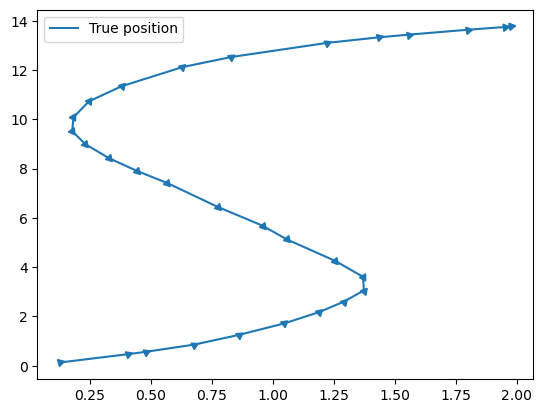

In [7]:
plt.plot(true_positions[:, 0], true_positions[:, 1], color="C0", label="True position")
for true_position in true_positions:
    plt.plot(
        true_position[0],
        true_position[1],
        marker=(3, 0, np.rad2deg(true_position[2])),
        color="C0",
    )
plt.legend();

In [8]:
observed_distances = distances(true_positions[..., :2], landmarks)

In [9]:
particles, log_weights, neffs, rng_updates = particle_filter(
    rng=rng,
    observed_distances=observed_distances,
    landmarks=landmarks,
    heading_changes=intended_headings,
    velocities=intended_velocities,
    heading_noise=heading_noise,
    velocity_noise=velocity_noise,
    sensor_noise=sensor_noise * 2,
    dt=dt,
    n_particles=1000,
    initial_particles=None,
)

In [10]:
estimate_mean, estimate_std = estimate(particles, log_weights)

func = pytensor.function([], [estimate_mean, estimate_std, particles, log_weights, neffs], updates=rng_updates)

In [11]:
mean, std, parts, lws, neffs = func()

In [12]:
neffs

array([ 45.06759826, 154.07591109, 506.84658165, 193.62834441,
       550.04902585, 255.25951101, 654.81421472, 379.19125097,
       686.5101707 , 419.29741896, 753.32719965, 443.27006312,
       732.37477667, 399.39162703, 270.98097829, 679.42941573,
       384.49971935, 681.73532008, 340.29482615, 626.62568288,
       355.18695443, 731.05710619, 283.02408421, 704.21433365,
       208.96256994, 706.75162769, 432.04024528, 729.63776185,
       460.4651018 , 701.08854833])

In [13]:
# func.dprint()

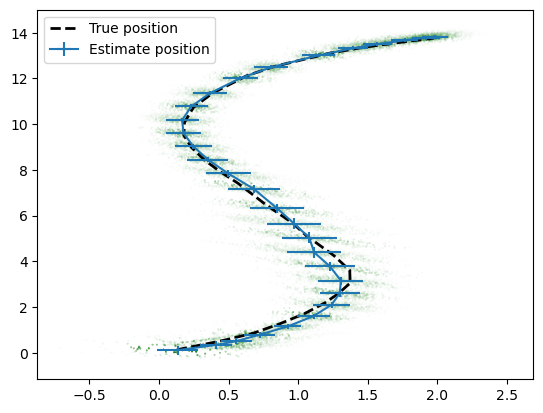

In [14]:
plt.plot(
    true_positions[:, 0],
    true_positions[:, 1],
    ls="--",
    lw=2,
    color="k",
    label="True position",
)
plt.errorbar(
    mean[:, 0], mean[:, 1], std[:, 0], std[:, 1], color="C0", label="Estimate position"
)
plt.scatter(parts[..., 0], parts[..., 1], c="green", s=np.exp(lws) * 100, alpha=0.05)
plt.legend();

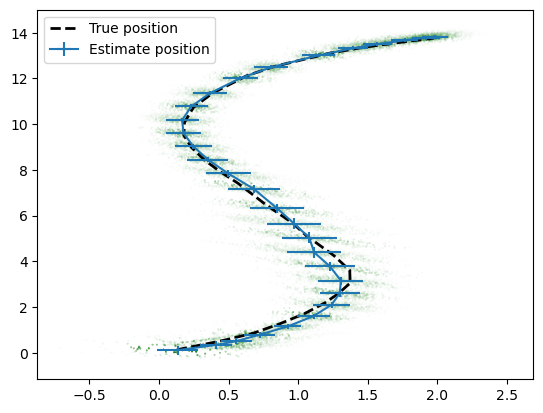

In [15]:
plt.plot(
    true_positions[:, 0],
    true_positions[:, 1],
    ls="--",
    lw=2,
    color="k",
    label="True position",
)
plt.errorbar(
    mean[:, 0], mean[:, 1], std[:, 0], std[:, 1], color="C0", label="Estimate position"
)
plt.scatter(parts[..., 0], parts[..., 1], c="green", s=np.exp(lws) * 100, alpha=0.05)
plt.legend();

https://filterpy.readthedocs.io/en/latest/_modules/filterpy/monte_carlo/resampling.html#systematic_resample